<a href="https://colab.research.google.com/github/umbertogagl97/exercise/blob/main/Attacchi_ART_VGG16_stl10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importa ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 8.6 MB/s 
     |████████████████████████████████| 3.4 MB 37.8 MB/s 
     |████████████████████████████████| 25.3 MB 81 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
#Librerie
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier
from art.utils import load_dataset
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# Read CIFAR10 dataset    
#10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
#96x96 pixels, colored.
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("stl10")) #carica train e test set
x_train, y_train = x_train[:500], y_train[:500] #prende solo le prime 500 immagini di training
x_test, y_test = x_test[:10], y_test[:10] #e le prime 10 di test
im_shape = x_train[0].shape
print("dimensioni immagine: ",im_shape)
print("dimensioni train set: ",x_train.shape)
print("dimensioni vettore classi reali: ",y_train.shape)
print("dimensioni test set: ",x_test.shape)

dimensioni immagine:  (96, 96, 3)
dimensioni train set:  (500, 96, 96, 3)
dimensioni vettore classi reali:  (500, 10)
dimensioni test set:  (10, 96, 96, 3)


In [ ]:
#creazione rete usando vgg16 preaddestrata e aggiungendo gli ultimi livelli per adattarla al problema di 10 classi
from tensorflow.keras.applications.vgg16 import VGG16

#importa rete vgg16 addestrata sul dataset imagenet, esclude gli ultimi livelli e come input pongo dimensioni 96,96,3 
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(im_shape[0],im_shape[1],im_shape[2]))

# Freeze all the layers (non modifico i pesi dei livelli inferiori)
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# creo un modello aggiungendo livelli alla rete importata
model = Sequential()
# Add the vgg convolutional base model
model.add(vgg_conv)
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) #10: numero di valori in uscita (le classi)

#stampa info del modello
model.summary()

# Configure the model for training (setta i parametri del modello)
import keras
model.compile(
        loss=keras.losses.categorical_crossentropy, optimizer=Adam(learning_rate=0.01), metrics=["accuracy"]
    )

# Train the model: divisione del training set in training e validation con rapporto 80-20
history= model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4719616   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 19,444,554
Trainable params: 4,729,866
Non-trainable params: 14,714,688
_________________________________________________________________
Train on 400 samples, validate on 100

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


400/400 [==============================] - 27s 68ms/sample - loss: 28.6091 - accuracy: 0.1550 - val_loss: 21.6448 - val_accuracy: 0.1800
Epoch 2/10
400/400 [==============================] - 26s 65ms/sample - loss: 18.4243 - accuracy: 0.2525 - val_loss: 7.5497 - val_accuracy: 0.3900
Epoch 3/10
400/400 [==============================] - 26s 65ms/sample - loss: 6.9981 - accuracy: 0.3175 - val_loss: 2.2184 - val_accuracy: 0.3700
Epoch 4/10
400/400 [==============================] - 26s 65ms/sample - loss: 2.2642 - accuracy: 0.4525 - val_loss: 1.6323 - val_accuracy: 0.4600
Epoch 5/10
400/400 [==============================] - 26s 65ms/sample - loss: 1.4078 - accuracy: 0.5625 - val_loss: 1.3327 - val_accuracy: 0.5300
Epoch 6/10
400/400 [==============================] - 26s 65ms/sample - loss: 1.1533 - accuracy: 0.5900 - val_loss: 1.3097 - val_accuracy: 0.5700
Epoch 7/10
400/400 [==============================] - 26s 64ms/sample - loss: 1.1079 - accuracy: 0.6250 - val_loss: 1.3321 - val_acc

In [ ]:
#creazione classificatore di tipo Keras usando il modello addestrato, poiché ART supporta solo determinati classificatori
classifier = KerasClassifier(model=model, clip_values=(min_, max_)) #è un wrapper messo a disposizione da ART per creare un classificatore a partire da un modello addestrato

In [ ]:
#resized=cv2.resize(x_test1[1,:,:,:],(500,500),interpolation=cv2.INTER_CUBIC)

In [ ]:
# Evaluate the classifier on the test set 
value_preds=classifier.predict(x_test) #contiene i valori tra 0 e 1 predetti per ognuna delle 10 classi e per ogni immagine
preds = np.argmax(value_preds, axis=1) #(le predizioni vanno da 0 a 9 e indicano la classe predetta)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Accuracy on test set:", (acc * 100))
print("classi predette: ",preds)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on test set: 40.0
classi predette:  [6 1 4 8 5 6 1 1 3 4]


In [ ]:
# FGM
attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv2 = attack.generate(x=x_test,y=y_test) #aggiunge una perturbazione alle immagini del test set
#N.B. si possono passare le classi reali del test set (con y=y_test) e in questo caso FGM calcolerà le perturbazioni in modo che il classificatore
#non predica queste classi. Mentre, se non passo y_test, le calcolerà in modo da non fargli predire la classe predetta normalmente (la quale può essere diversa da quella reale
#se il classificatore non è corretto)
perturb=x_test_adv2-x_test #calcolo della perturbazione

#N.B. problema nel calcolo della perturbazione, con la sottrazione si ha un'immagine [-1,1], di seguito è normalizzata in [0,1]
min_p, max_p = np.amin(perturb), np.amax(perturb)
perturb = (perturb - min_p) / (max_p - min_p)
#se non normalizzo, la funzione che uso per stampare ritaglia automaticamente nell'intervallo [0,1] quindi perdo informazioni

In [ ]:
# Evaluate the classifier on the adversarial samples FGM
value_preds_after=classifier.predict(x_test_adv2)
preds_after = np.argmax(value_preds_after, axis=1)
acc_after = np.sum(preds_after == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Accuracy on adversarial samples:", (acc_after * 100))
print("classi predette su test set perturbato: ",preds_after)

Accuracy on adversarial samples: 0.0
classi predette su test set perturbato:  [4 3 3 3 5 6 6 4 5 1]


Immagine  0


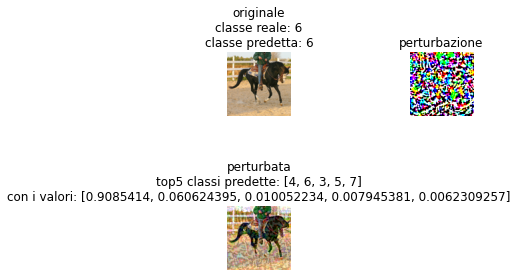

Immagine  1


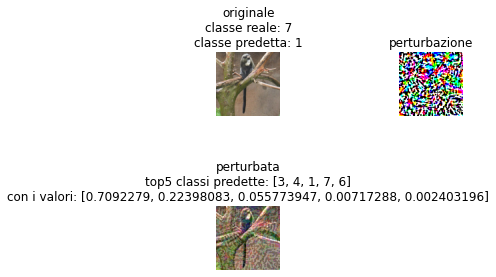

Immagine  2


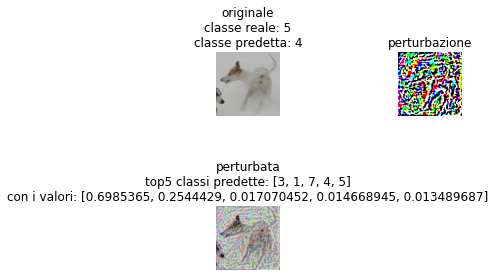

Immagine  3


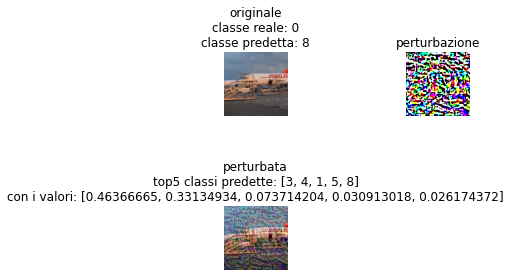

Immagine  4


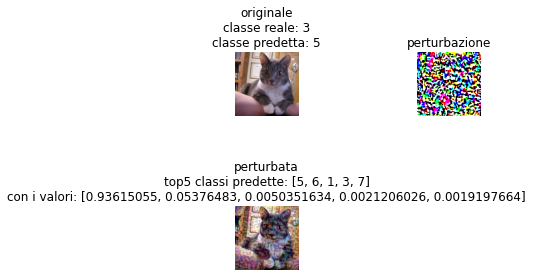

Immagine  5


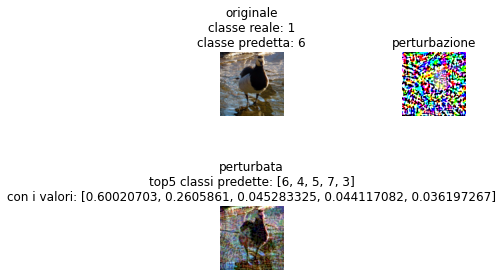

Immagine  6


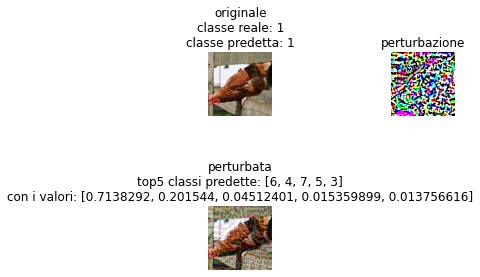

Immagine  7


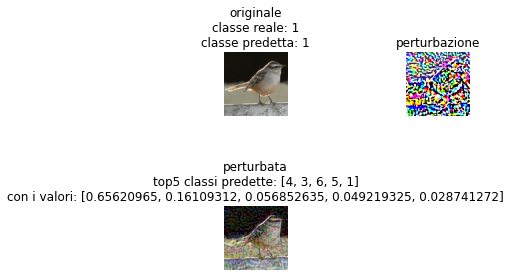

Immagine  8


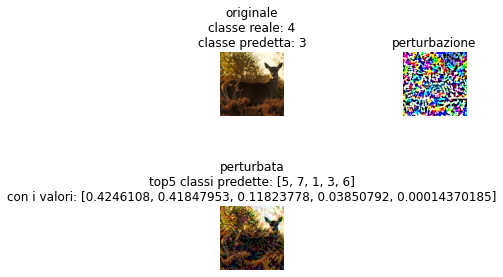

Immagine  9


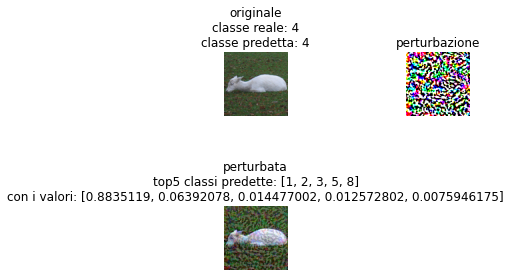

In [ ]:
#stampa subplot

#cv2_imshow(cv2.hconcat([x_test[0,:,:,:]*255,x_test[1,:,:,:]*255,x_test[2,:,:,:]*255]))
#N.B. plt.imshow usa range 0,1 per immagini rgb, mentre cv2 usa 0,255
import matplotlib.pyplot as plt    
#nel seguente ciclo for si crea un vettore delle classi predette ordinato per probabilità decrescente
for i in range(x_test.shape[0]):
  value=value_preds_after[i,:]
  value_sorted=sorted(value,reverse=True)
  classes=[]
  for j in range(value.size) :
    ind=np.where(value==value_sorted[j]) #restituisce l'indice in value del valore uguale a value_sorted[i], quindi è la classe
    classes.append(ind[0][0]) #classes è il vettore finale
  
  #in seguito per ogni immagine del test set si stampa un subplot
  fig = plt.figure()
  print("Immagine ",i)
  #originale
  ax1 = fig.add_subplot(321) #subplot con 3 righe e due colonne
  ax1.axis('off')
  ax1.imshow(cv2.rotate(x_test[i,:,:,:],cv2.cv2.ROTATE_90_CLOCKWISE))
  ax1.title.set_text("originale\nclasse reale: "+str(np.argmax(y_test[i,:]))+"\nclasse predetta: "+str(preds[i]))
  #perturbazione
  ax2 = fig.add_subplot(322)
  ax2.imshow(cv2.rotate(perturb[i,:,:,:],cv2.cv2.ROTATE_90_CLOCKWISE))
  ax2.axis('off')
  ax2.title.set_text("perturbazione")
  #perturbata
  ax3 = fig.add_subplot(325)
  ax3.imshow(cv2.rotate(x_test_adv2[i,:,:,:],cv2.cv2.ROTATE_90_CLOCKWISE))
  ax3.axis('off')
  ax3.title.set_text("perturbata\ntop5 classi predette: "+str(classes[:5])+"\ncon i valori: "+str(value_sorted[:5]))

  plt.show()

In [ ]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def perturb_img(img_g : np.ndarray,real_class : int):
  img_g=cv2.resize(img_g,(96,96))
  print("\nImmagine originale, classe reale: ",real_class)
  cv2_imshow(img_g)

  min_, max_ = np.amin(img_g), np.amax(img_g)
  normalized_img_g = (img_g - min_) / (max_ - min_) #normalizzo tra [0,1]
  normalized_img_g=normalized_img_g.reshape(1,96,96,3)

  pred_value=classifier.predict(normalized_img_g)
  pred=np.argmax(pred_value)
  print("Classe predetta: ",pred)
  print("Valori predetti per ogni classe:\n",pred_value)
  #generazione perturbazione
  img_adv = attack.generate(x=normalized_img_g)
  print("\nImmagine perturbata")
  cv2_imshow(img_adv[0,:,:,:]*max_)
  pred_value_adv=classifier.predict(img_adv)
  pred_adv=np.argmax(pred_value_adv)
  print("Classe predetta: ",pred_adv)
  print("Valori predetti per ogni classe:\n",pred_value_adv)


Immagine originale, classe reale:  0


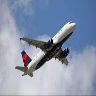

Classe predetta:  0
Valori predetti per ogni classe:
 [[9.81577337e-01 1.21499272e-02 1.20446144e-04 1.65398160e-04
  1.27281388e-03 2.76097190e-03 6.39505277e-04 3.44028849e-05
  6.62002247e-04 6.17103942e-04]]

Immagine perturbata


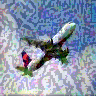

Classe predetta:  4
Valori predetti per ogni classe:
 [[1.1058568e-03 7.2065569e-02 7.9496873e-05 2.4416707e-01 2.8275990e-01
  2.5253716e-01 7.1129568e-02 7.5493477e-02 3.2478073e-04 3.3713382e-04]]

Immagine originale, classe reale:  5


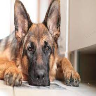

Classe predetta:  0
Valori predetti per ogni classe:
 [[0.47896448 0.34214872 0.00292668 0.00331754 0.01099909 0.07039846
  0.00361072 0.00128057 0.07483555 0.01151822]]

Immagine perturbata


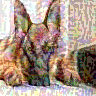

Classe predetta:  3
Valori predetti per ogni classe:
 [[1.8524991e-03 8.3649032e-02 3.4943459e-04 3.6850780e-01 1.3761197e-01
  1.0193708e-01 5.3573802e-02 2.4974711e-01 1.8635135e-03 9.0767612e-04]]


In [ ]:
#test su immagini di google

#10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.

path_img_drive="/content/gdrive/MyDrive/immagini_google/"

img_g1=cv2.imread(path_img_drive+"airplane.jpg")
img_g2=cv2.imread(path_img_drive+"dog.jpg")

perturb_img(img_g1,0)
perturb_img(img_g2,5)




In [ ]:
!git clone https://github.com/LTS4/DeepFool.git
%cd DeepFool/Python/

[Errno 2] No such file or directory: 'DeepFool/Python/'
/content/DeepFool/Python


In [ ]:
%ls

deepfool.py  synset_words.txt  test_im1.jpg
README.md    test_deepfool.py  test_im2.jpg


In [ ]:
!pip install torch.autograd.gradcheck


ERROR: Could not find a version that satisfies the requirement torch.autograd.gradcheck (from versions: none)
ERROR: No matching distribution found for torch.autograd.gradcheck


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import math
import torchvision.models as models
from PIL import Image
import deepfool
import os

net = models.resnet34(pretrained=True)

# Switch to evaluation mode
net.eval()

im_orig = Image.open('test_im2.jpg')

mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]


# Remove the mean
im = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean,
                         std = std)])(im_orig)

r, loop_i, label_orig, label_pert, pert_image = deepfool.deepfool(im, net)

labels = open(os.path.join('synset_words.txt'), 'r').read().split('\n')

str_label_orig = labels[np.int(label_orig)].split(',')[0]
str_label_pert = labels[np.int(label_pert)].split(',')[0]

print("Original label = ", str_label_orig)
print("Perturbed label = ", str_label_pert)

def clip_tensor(A, minv, maxv):
    A = torch.max(A, minv*torch.ones(A.shape))
    A = torch.min(A, maxv*torch.ones(A.shape))
    return A

clip = lambda x: clip_tensor(x, 0, 255)

tf = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=map(lambda x: 1 / x, std)),
                        transforms.Normalize(mean=map(lambda x: -x, mean), std=[1, 1, 1]),
                        transforms.Lambda(clip),
                        transforms.ToPILImage(),
                        transforms.CenterCrop(224)])

plt.figure()
plt.imshow(tf(pert_image.cpu()))
plt.title(str_label_pert)
plt.show()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Using CPU
Original label =  n03538406 horse cart
Perturbed label =  n02437312 Arabian camel


TypeError: ignored

<Figure size 432x288 with 0 Axes>